In [ ]:
import re
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from netCDF4 import Dataset
import geopandas as gpd
from shapely.geometry import Point, box
import pandas as pd
import calendar
from datetime import datetime, timedelta
import seaborn as sns


from tqdm import tqdm
import rasterio
import rioxarray
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import mapping

In [2]:
import pandas as pd

### Factor A

In [2]:
FactorA_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorA_DONE_Year_2017.csv')

In [3]:
FactorA_df = FactorA_df.drop(columns = ['Unnamed: 0', 'index'])

### Factor B

In [4]:
FactorB_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorB_DONE_Year_2017.csv')

In [5]:
FactorB_df = FactorB_df.drop(columns = ['Unnamed: 0', 'index', 'interpolated_precip', 'status', 'temp'])

### Factor C

In [6]:
FactorC_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorC_DONE_Year_2017.csv')

### Estimated Soil NOx Emission

In [7]:
FactorA_df_columns = ['lat', 'lon', 'interpolated_precip', 'temp', 'time', 'status',
       'planned crops', 'F [N Requirement]', 'Factor_A']

In [8]:
FactorB_df_columns = ['lat', 'lon', 'moisture', 'time', 'sum_precip_14_days', 'Pulsing Level',
       'Pulsing Day', 'Factor B Pulsing Effect']

In [9]:
FactorC_df_columns = ['lat', 'lon', 'interpolated_LAI', 'interpolated_FAPAR', 'time', 'SAI',
       'CR']

In [11]:
# Ensure 'time' column is of the same type (preferably datetime) in all dataframes
FactorA_df['time'] = pd.to_datetime(FactorA_df['time'])
FactorB_df['time'] = pd.to_datetime(FactorB_df['time'])
FactorC_df['time'] = pd.to_datetime(FactorC_df['time'])

# Merge FactorA and FactorB on 'lat', 'lon', and 'time'
merged_AB = pd.merge(FactorA_df, FactorB_df, on=['lat', 'lon', 'time'], how='outer')

# Merge the result with FactorC on 'lat', 'lon', and 'time'
merged_ABC = pd.merge(merged_AB, FactorC_df, on=['lat', 'lon', 'time'], how='outer')

In [12]:
def Estimated_Soil_NOx_Emission_Calculator(A, B, C):
    return A * B * C


In [ ]:
merged_ABC['Estimated_Soil_NOx_Emission'] = merged_ABC.apply(lambda row: Estimated_Soil_NOx_Emission_Calculator(row['Factor_A'], row['Factor B Pulsing Effect'], row['CR']), axis=1)
merged_ABC = merged_ABC.dropna()
# merged_ABC.to_csv('/global/scratch/users/liuwenjin021011/data/Estimated_Soil_NOx_Emission_Year_2017.csv', header = True, index = False)


## Visualization

In [7]:
df_2017 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/Estimated_Soil_NOx_Emission_Year_2017.csv')
df_2018 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/Estimated_Soil_NOx_Emission_Year_2018.csv')
df_2019 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/Estimated_Soil_NOx_Emission_Year_2019.csv')

In [5]:
df

,lat,lon,interpolated_precip,temp,time,status,planned crops,F [N Requirement],Factor_A,moisture,sum_precip_14_days,Pulsing Level,Pulsing Day,Factor B Pulsing Effect,interpolated_LAI,interpolated_FAPAR,SAI,CR,geometry,Estimated_Soil_NOx_Emission
0,25.412697,97.328835,0.0,19.17635,2017-12-24,dry,[],0.0,1.310384,0.348123,5.486522e+00,No Pulse,0.0,1.0,4.495672,0.746114,0.0000,0.918025,POINT (97.3288345336914 25.412696838378903),1.202965
1,25.412697,97.422195,0.0,18.96480,2017-12-24,dry,[],0.0,1.295928,0.352620,5.066509e+00,No Pulse,0.0,1.0,5.026400,0.792198,0.0000,0.913427,POINT (97.42219543457033 25.412696838378903),1.183735
2,25.412697,97.515564,0.0,18.41200,2017-12-24,dry,[],0.0,1.258153,0.351858,4.878786e+00,No Pulse,0.0,1.0,4.500093,0.708052,0.0000,0.921861,POINT (97.51556396484376 25.412696838378903),1.159842
3,25.412697,99.009338,0.0,9.18905,2017-12-24,dry,"[""Corn"", ""Rice"", ""Barley"", ""Wheat"", ""Soybeans""...",0.0,0.627918,0.205346,1.421085e-14,No Pulse,0.0,1.0,1.479043,0.618750,0.0047,0.910855,POINT (99.00933837890624 25.412696838378903),0.571942
4,25.412697,99.102699,0.0,9.26666,2017-12-24,dry,"[""Corn"", ""Rice"", ""Barley"", ""Wheat"", ""Soybeans""...",0.0,0.633222,0.240925,2.131628e-14,No Pulse,0.0,1.0,1.458022,0.569417,0.0047,0.915988,POINT (99.10269927978516 25.412696838378903),0.580023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25265124,37.829597,118.988586,0.0,2.11724,2017-12-31,dry,[],0.0,0.144678,0.217637,0.000000e+00,No Pulse,0.0,1.0,0.032217,0.119596,0.0000,0.985852,POINT (118.98858642578124 37.82959747314453),0.142631
25265125,37.829597,119.081947,0.0,2.41244,2017-12-31,dry,[],0.0,0.164850,-9999.000000,2.870896e-02,No Pulse,0.0,1.0,0.040627,0.118478,0.0000,0.985983,POINT (119.08194732666016 37.82959747314453),0.162539
25265126,37.829597,119.175308,0.0,2.57995,2017-12-31,dry,[],0.0,0.176297,-9999.000000,1.353119e-01,No Pulse,0.0,1.0,0.049038,0.117360,0.0000,0.986113,POINT (119.17530822753906 37.82959747314453),0.173848
25265127,37.829597,119.268669,0.0,2.65408,2017-12-31,dry,[],0.0,0.181362,-9999.000000,2.419148e-01,No Pulse,0.0,1.0,0.057449,0.116242,0.0000,0.986244,POINT (119.26866912841795 37.82959747314453),0.178867


In [ ]:
def filter_points_within_shape(df, shapefile_path, column='Estimated_Soil_NOx_Emission'):
    # Compute the average of the column of interest
    avg_df = df.groupby(['lat', 'lon'])[column].mean().reset_index()
    avg_df.rename(columns={column: 'avg_Estimated_Soil_NOx_Emission'}, inplace=True)
    print(avg_df.shape)

    # Convert df to a GeoDataFrame
    gdf = gpd.GeoDataFrame(avg_df, geometry=gpd.points_from_xy(avg_df.lon, avg_df.lat))

    # Set the coordinate reference system (CRS)
    gdf.set_crs(epsg=4326, inplace=True)  # EPSG:4326 is WGS84, adjust as necessary

    # Load the shapefile
    base_map = gpd.read_file(shapefile_path)
    base_map.set_crs(epsg=4326, inplace=True)

    # Perform spatial join to keep only points within the shapefile boundaries
    gdf_within_shape = gpd.sjoin(gdf, base_map, how="inner", op='intersects')

    # Drop the 'index_right' column if exists
    if 'index_right' in gdf_within_shape.columns:
        gdf_within_shape.drop(columns=['index_right'], inplace=True)

    return gdf_within_shape

def plot_Estimated_Soil_NOx_Emission_within_shape(df, shapefile_path, title='2017 Year-Round Average Estimated Soil NOx Emission', vmin=0, vmax=50):
    # Filter points to keep only those within the shapefile
    filtered_df = filter_points_within_shape(df, shapefile_path, 'Estimated_Soil_NOx_Emission')

    # Load the shapefile
    base_map = gpd.read_file(shapefile_path)
    base_map.set_crs(epsg=4326, inplace=True)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    base_map.plot(ax=ax, color='white', edgecolor='black', alpha=0)  # Plot the base map first with no fill color
    filtered_df.plot(ax=ax, column='avg_Estimated_Soil_NOx_Emission', cmap='Blues', legend=True, markersize=2, alpha=0.5, vmin=vmin, vmax=vmax)  # Then plot the data points
    base_map.boundary.plot(ax=ax, edgecolor='black')  # Plot the boundaries on top

    
    # Set larger font sizes
    plt.title(title, fontsize=20)  # Larger font size for the title
    plt.xlabel('Longitude', fontsize=16)  # Larger font size for the x-axis label
    plt.ylabel('Latitude', fontsize=16)  # Larger font size for the y-axis label
    plt.xticks(fontsize=12)  # Larger font size for the x-axis ticks
    plt.yticks(fontsize=12)  # Larger font size for the y-axis ticks
    plt.show()
    
    
shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Province-Doundary-Shape.shp'
plot_Estimated_Soil_NOx_Emission_within_shape(df, shapefile_path)


## Annual Soil NOx Emission Magnitude Check

In [8]:
# Estimated_Soil_NOx_Emission Unit: ng * N / (m^2 * s)

def find_resolution(arr):

    arr = np.array(np.unique(arr))
    sorted_arr = np.sort(arr)
    differences = np.diff(sorted_arr)
    avg_difference = np.mean(differences)

    return avg_difference

def grid_area(lat_res, lon_res):
    # Average latitude and longitude length per degree (in meters)
    avg_lat_length_per_degree = 111111  # approximately 111 km per degree of latitude
    avg_lon_length_per_degree = 111139  # approximately 111.32 km at the equator for longitude

    # Convert latitude and longitude resolution from degrees to meters
    lat_length = lat_res * avg_lat_length_per_degree
    lon_length = lon_res * avg_lon_length_per_degree

    # Calculate the area of the grid cell in square meters
    area = lat_length * lon_length

    return area


def calculate_total_nox_emission(df, lat_res, lon_res):
    # Calculate the area for each grid cell
    # df['Area'] = df.apply(lambda row: grid_area(row['lat'], row['lon'], lat_res, lon_res), axis=1)
    Area = grid_area(lat_res, lon_res)
    # Time period in seconds (1 day)
    seconds_per_day = 24 * 60 * 60

    # Convert NOx flux from ng/(m^2·s) to kg over one day and calculate the total emission for each grid cell
    df['Total_NOx_kg'] = df['Estimated_Soil_NOx_Emission'] * Area * seconds_per_day * 1e-12

    # Sum the total NOx emission over all grid cells to get the total emission for China
    total_nox_emission_kg = df['Total_NOx_kg'].sum()

    return total_nox_emission_kg


# lat & lon resolution 
lat_res = 0.1 # find_resolution(df['lat'])
lon_res = 0.1 # find_resolution(df['lon'])

total_nox_emission_kg = calculate_total_nox_emission(df_2017, lat_res, lon_res)
print(f"Total NOx emission over China in 2017: {total_nox_emission_kg * 1e-6} Gg/yr")

total_nox_emission_kg = calculate_total_nox_emission(df_2018, lat_res, lon_res)
print(f"Total NOx emission over China in 2018: {total_nox_emission_kg * 1e-6} Gg/yr")

total_nox_emission_kg = calculate_total_nox_emission(df_2019, lat_res, lon_res)
print(f"Total NOx emission over China in 2019: {total_nox_emission_kg * 1e-6} Gg/yr")

Total NOx emission over China in 2017: 3019.2268646910184 Gg/yr
Total NOx emission over China in 2018: 2176.1527447741805 Gg/yr
Total NOx emission over China in 2019: 1663.8443906053124 Gg/yr


In [ ]:
print('Based on Our Estimate, Soil NOx Emission Contributes', 3019.2268646910184 / 17852, 'of Total NOx Emission')

In [ ]:
# MultiSource Paper Result: 3741 Gg/yr, 17.3% of the total emissions [17,852 Gg]

In [14]:
df_2017 = df_2017[['time', 'Total_NOx_kg']]
df_2018 = df_2018[['time', 'Total_NOx_kg']]
df_2019 = df_2019[['time', 'Total_NOx_kg']]

/tmp/ipykernel_139374/2868931379.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2017['time'] = pd.to_datetime(df_2017['time'])
/tmp/ipykernel_139374/2868931379.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018['time'] = pd.to_datetime(df_2018['time'])
/tmp/ipykernel_139374/2868931379.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

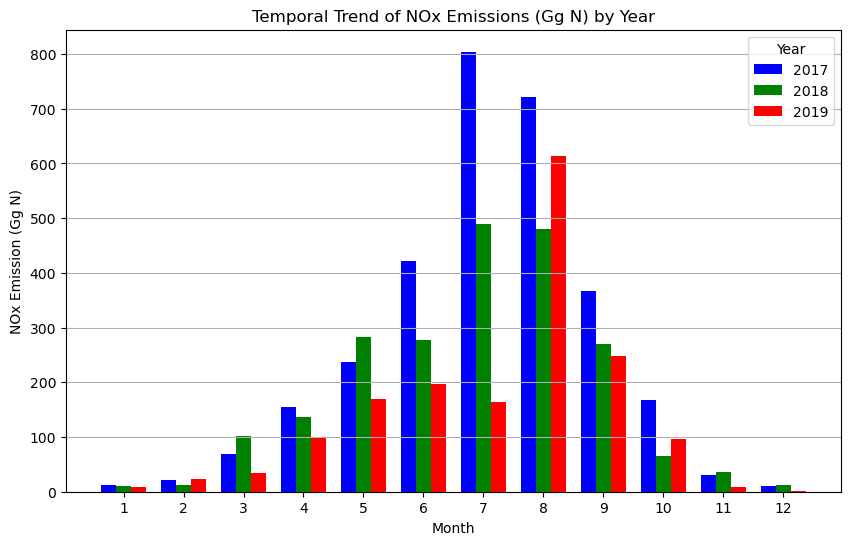

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_temporal_trend_NOx_side_by_side(df_2017, df_2018, df_2019):
    # Prepare the data for each year
    
    df_2017['time'] = pd.to_datetime(df_2017['time'])
    df_2018['time'] = pd.to_datetime(df_2018['time'])
    df_2019['time'] = pd.to_datetime(df_2019['time'])
    
    df_2017['month'] = df_2017['time'].dt.month
    df_2018['month'] = df_2018['time'].dt.month
    df_2019['month'] = df_2019['time'].dt.month
    
    data_frames = [df_2017, df_2018, df_2019]
    colors = ['blue', 'green', 'red']
    labels = ['2017', '2018', '2019']
    width = 0.25  # the width of the bars

    plt.figure(figsize=(10, 6))

    # Plotting each year's data
    for i, df in enumerate(data_frames):
        # Ensure 'month' is of type int
        df['month'] = df['month'].astype(int)
        
        # Convert kg N to Gg N (1 Gg = 1e6 kg)
        df['NOx_Gg_N'] = df['Total_NOx_kg'] / 1e6

        # Aggregate NOx emissions by month
        monthly_NOx = df.groupby('month')['NOx_Gg_N'].sum().reset_index()
        
        # Create x positions for the bars
        x_positions = monthly_NOx['month'] - width + i * width

        # Plot
        plt.bar(x_positions, monthly_NOx['NOx_Gg_N'], width=width, color=colors[i], label=labels[i])

    # Adding labels and titles
    plt.title('Temporal Trend of NOx Emissions (Gg N) by Year')
    plt.xlabel('Month')
    plt.ylabel('NOx Emission (Gg N)')
    plt.xticks(ticks=range(1, 13), labels=[str(m) for m in range(1, 13)])  # Month labels from 1 to 12
    plt.grid(axis='y')
    plt.legend(title='Year')

    # Show plot
    plt.show()

plot_temporal_trend_NOx_side_by_side(df_2017, df_2018, df_2019)